In [1]:
from dask_kubernetes import KubeCluster
from dask.distributed import Client, progress
import dask.array as da
import numpy as np
import pandas as pd
import zarr
import allel
import sys
import ag3
import psutil
from humanize import naturalsize
import numba

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# set up a method to call ktypes based on SVM or KNN.

In [10]:


# Data storage, uses about 34 MB
pca_cloud_zarr_path_template = 'vo_agam_production/ag3_data_paper/{}.pca_output.zarr'
# Writing the PCA data to the cloud will require the appropriate authentication and authorization.

import gcsfs
# UNCOMMENT THIS TO AUTHENTICATE. YOU ONLY NEED TO RUN THIS ONCE.
# After running this once, your authentication token should then be cached in `~/.gcs_tokens`
# Once you have authenticated, you should comment this out again to avoid re-authenticating.
# gcs_browser = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='browser')

# Use `cache_timeout=0` to prevent object list cache, to avoid recreating map for Zarr consolidated metadata
auth_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)



In [11]:

pca_cloud_zarr_path = pca_cloud_zarr_path_template.format('gamb_colu_arab_pca')
pca_cloud_zarr_path



'vo_agam_production/ag3_data_paper/gamb_colu_arab_pca.pca_output.zarr'

In [13]:
# Sometimes errors with `overwrite=True`, sometimes errors without, when dir not exist
# Keep the zarr_store for zarr.consolidate_metadata(zarr_store)
zarr_store = auth_fs.get_mapper(pca_cloud_zarr_path)
zarr_group = zarr.group(zarr_store)



In [14]:
sample_names = zarr_group["sample_names"][:]
sample_names = [s.decode() for s in sample_names]

In [15]:
pca_coordinates = zarr_group["coords"]
pca_components = zarr_group["components"]
pca_pve = zarr_group["explained_variance_ratio"]

In [17]:
from ag3 import release_data

In [19]:
v3 = release_data()

In [20]:
all_meta = v3.load_sample_set_metadata(v3.all_wild_sample_sets)

/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
cdict = {"gamb_colu": "orange", "arabiensis": "blue", "intermediate":"green"}

In [25]:
all_meta["species_colours"] = all_meta.species_gambcolu_arabiensis.map(cdict)

In [27]:
import seaborn as sns

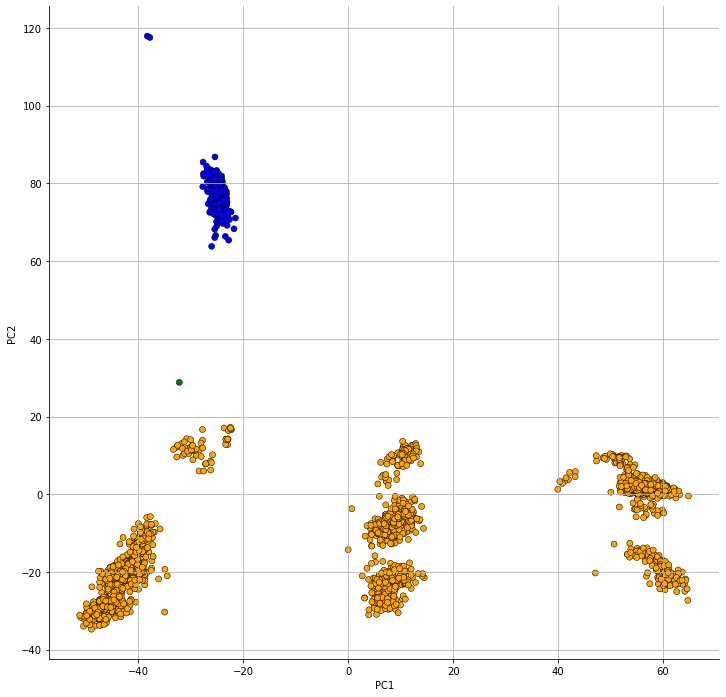

In [28]:
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.scatter(pca_coordinates[:, 0], pca_coordinates[:, 1], c=all_meta["species_colours"], edgecolor='k', lw=0.5)
ax.grid(True)
ax.set_xlabel(f"PC1")
ax.set_ylabel(f"PC2")
sns.despine(ax=ax)
#f.savefig("../content/images/pca/2La_karyotypes.svg", dpi=200)

In [55]:
def call_inversion_status(v):
    if v < -20:
        return 2
    elif v > 35:
        return 1
    else:
        return 0

In [73]:
pca1 = pd.Series(pca_coordinates[:, 0], sample_names)

call_2La = pca1.map(call_inversion_status)
call_2La.name = "kt_2La"

In [74]:
import yaml

In [75]:
with open("../content/population_definitions.yml") as f:
    definitions = yaml.load(f, Loader=yaml.Loader)

In [76]:
sample_ids = []
grouping = []
for k, v in definitions.items():
    for x in v:
        sample_ids.append(x)
        grouping.append(k)

population_definitions = pd.Series(grouping, index=sample_ids, name="sampling_group").reindex(all_meta.index)

In [78]:
all_meta["population_definitions"] = population_definitions
all_meta["2La_kt"] = call_2La

In [79]:
x = pd.crosstab(all_meta["population_definitions"], all_meta["2La_kt"])

In [80]:
x["n_samples"] = x.sum(axis=1)
x["frac_2La"] = (x[1] + 2*x[2]) / (2 * x["n_samples"])
x.head()

2La_kt,0,1,2,n_samples,frac_2La
population_definitions,,,,,
ANG_1_coluzzii_2009,4,77,0,81,0.475309
BUF_1_coluzzii_2012,2,0,80,82,0.975610
BUF_1_coluzzii_2014,2,0,51,53,0.962264
BUF_1_gambiae_2012,17,0,82,99,0.828283
BUF_1_gambiae_2014,7,0,39,46,0.847826


In [81]:
summary_2la = x.sort_values("frac_2La", ascending=False)
summary_2la.to_csv("../content/tables/karotype_summary_2La.csv")
summary_2la.head()

2La_kt,0,1,2,n_samples,frac_2La
population_definitions,,,,,
MLW_1_arabiensis_2015,0,0,41,41,1.0
TZA_1_arabiensis_2015,0,0,137,137,1.0
MAL_5_coluzzii_2004,0,0,11,11,1.0
UGA_2_arabiensis_2012,0,0,81,81,1.0
TZA_3_arabiensis_2012,0,0,40,40,1.0


In [82]:
# Given arabiensis is fixed for the inverted form... we can assume PC1 < -20 is 
call_2La.to_csv("../content/tables/karyotype_status_2La.csv")